# Deliverable 6.1 — Robust Tube MPC Position Controller (z-axis only)

**Objective:** Design a robust tube MPC controller for the z-subsystem to drive the rocket from z=10m to z=3m while robustly satisfying the ground constraint z≥0 under disturbances w ∈ [-15, 5].

**System:**
- States: x = [vz, z]ᵀ (vertical velocity and position)
- Input: u = Pavg (average throttle, 40-80%)
- Disturbance: w ∈ W = [-15, 5] (vertical force)
- Hard constraint: z ≥ 0 (ground collision avoidance)

## 1. Setup and Imports

In [37]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Path setup
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Imports
from LandMPC.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *

%matplotlib widget

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Tube MPC Design Procedure

### 2.1 Theoretical Framework

**Tube MPC** guarantees robust constraint satisfaction by constructing a "tube" around a nominal trajectory through the following steps:

1. **Ancillary Controller K (LQR)**: Stabilizing feedback for disturbance rejection
2. **Robust Positively Invariant (RPI) Set E**: Bounds worst-case deviations from nominal trajectory
3. **Constraint Tightening**: Tighten state/input constraints by subtracting E (Pontryagin difference)
4. **Terminal Ingredients**: Compute maximal invariant terminal set Xf and terminal cost P
5. **Nominal MPC**: Optimize nominal trajectory over tightened constraints
6. **Tube Control Law**: Apply u = v* + K(x - z*) where v* is nominal input, z* is nominal state

### 2.2 Implementation Approach with W=[-15,5]


**Our Implementation:**

1. **LQR Design**: Strong feedback with Q_lqr = diag(10, 80), R_lqr = 0.1 achieves spectral radius ρ(A_K) ≈ 0.915

2. **RPI Computation**: Use Pontryagin sum algorithm (E₀ = W, Eₖ₊₁ = W ⊕ A_K·Eₖ) until convergence
   - Result: 82-facet polyhedron with bounds e_vz ∈ [-0.71, 0.70] m/s, e_z ∈ [-0.58, 0.20] m
   - No manual caps applied

3. **Constraint Tightening**: Pontryagin differences X̃ = X ⊖ E, Ũ = U ⊖ K·E
   - State tightening: minimal (~4% loss)
   - Input tightening: severe (67.5% loss → P_avg ∈ [48.3%, 61.3%])

4. **Terminal Set**: Compute maximal invariant set (27-facet polyhedron, not a box)




### 2.3 Tuning Parameters Summary

| Parameter | Value | Rationale |
|-----------|-------|----------|
| **Horizon H** | 4 s  | Balance between performance and computation |
| **LQR Weights** | Q_lqr = diag(10, 80) | Strong position tracking (Q₂₂=80), moderate velocity damping |
| | R_lqr = 0.1 | Low penalty for strong feedback authority |
| **RPI Set** | e_vz ∈ [-0.71, 0.70] m/s | Computed via minimal RPI algorithm (82 facets) |
| | e_z ∈ [-0.58, 0.20] m | No manual caps - true worst-case bounds |
| **MPC Weights** | Q_mpc = diag(50, 3000) | Very high position weight for tight tracking |
| | R_mpc = 0.5 | Moderate input penalty |
| **Terminal Set Xf** | 27-facet polyhedron | Maximal invariant set (NOT a box) |
| **Constraint Tightening** | P_avg ∈ [48.29, 61.31]% | 67.5% input authority loss for robustness |
| **Solver** | OSQP | max_iter=40000, eps_abs/rel=1e-3 |




### 2.4 Understanding RPI Set and Terminal Set Sizing

#### 2.4.1 RPI Set E: How Size is Determined

The **RPI set E** is computed using the Pontryagin sum recursion: E₀ = W, Eₖ₊₁ = W ⊕ A_K·Eₖ until convergence, where A_K = A + BK and W = {Bw : w ∈ [-15, 5]}.


**What controls size:** Disturbance magnitude, spectral radius ρ(A_K) ≈ 0.915, and LQR gains Q_lqr=[10,80], R_lqr=0.1.

#### 2.4.2 Terminal Set Xf: How Size is Determined

**Xf** is computed as the maximal robust control-invariant set: Xf = max{O : O ⊆ X̃, A_K·O ⊆ O, KO ⊆ Ũ}

Unlike simplified designs with box terminal sets (e.g., vz ∈ ±2.0, z ∈ ±1.0), we compute the largest possible region automatically.

#### 2.4.3 Constraint Tightening Results

**State Constraints:** δvz ∈ [-19.29, 9.30] m/s, δz ∈ [-2.42, 19.81] m → **3-4% loss**

**Input Constraints:** P_avg ∈ [48.29, 61.31]% (original: [40, 80]%) → **67.5% loss**

#### 2.4.4 Summary

| Set | Computed Size | How Determined |
|-----|---------------|----------------|
| **E** | vz: [-0.71, 0.70], z: [-0.58, 0.20] | Minimal RPI (82 facets) |
| **Xf** | 27-facet polyhedron | Maximal invariant set |
| **X̃** | vz∈[-19.29,9.30], z∈[-2.42,19.81] | X ⊖ E |
| **Ũ** | ΔP∈[-8.38,4.65]% | U ⊖ K·E |

**Key Insights:** Severe input tightening (67.5%) is the price for robust guarantees, but minimal state tightening (4%) and large terminal set maintain feasibility.


## 3. System Setup and Controller Initialization

In [38]:
# Rocket parameters
Ts = 1/20  # 20 Hz
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # kg (DO NOT CHANGE)

# Visualization
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

# Initial and reference states
x0 = np.array([0.]*9 + [0., 0., 10.])     # Start at z=10m
x_ref = np.array([0.]*9 + [1., 0., 3.])   # Target z=3m, vx=1m/s

# Trim point (hover at z=3m)
xs, us = rocket.trim(x_ref)



# Linearize
sys_lin = rocket.linearize_sys(xs, us)
A, B = sys_lin.A, sys_lin.B



In [39]:
# Create Tube MPC controller - WORLD RECORD MODE
H = 4 # SHORT horizon for absolute maximum speed
sim_time = 10.0  # Simulation length


mpc = MPCControl_z(A, B, xs, us, Ts, H)


[Tube MPC z] N=80, Ts=0.05, xs[z]=3.00, us=56.67
  LQR K=[-19.55993102 -25.86666986], |eig|max=0.915
  RPI bounds: vz∈[-0.713,0.696], z∈[-0.584,0.195]
  Tightened: Δvz∈[-19.29,9.30], Δz∈[-2.42,19.81], ΔPavg∈[-8.38,4.65]
  MPC setup complete.


## 4. Visualize Computed Sets

Display the RPI set E, tightened state constraint X̃, terminal set Xf, and tightened input constraint Ũ.

In [40]:
# Extract sets from controller
E = mpc.E              # RPI set (box approximation)
X_tilde = mpc.X_tilde  # Tightened state constraints
U_tilde = mpc.U_tilde  # Tightened input constraints
Xf = mpc.Xf            # Terminal set

print("="*70)
print("COMPUTED SETS INFORMATION")
print("="*70)

print(f"\n1. RPI Set E (box approximation):")
try:
    E.minimize()
    print(f"   Facets: {E.A.shape[0]}, Vertices: {E.V.shape[0]}")
    e_vz = np.max(np.abs(E.V[:, 0]))
    e_z = np.max(np.abs(E.V[:, 1]))
    print(f"   Bounds: vz ∈ ±{e_vz:.3f} m/s, z ∈ ±{e_z:.3f} m")
except:
    print(f"   Facets: {E.A.shape[0]}")
    print(f"   Bounds: vz ∈ ±{mpc.e_bound[0]:.3f} m/s, z ∈ ±{mpc.e_bound[1]:.3f} m")

print(f"\n2. Tightened State Constraints X̃:")
try:
    X_tilde.minimize()
    print(f"   Facets: {X_tilde.A.shape[0]}, Vertices: {X_tilde.V.shape[0]}")
except:
    print(f"   Facets: {X_tilde.A.shape[0]}")
print(f"   Bounds (delta coords):")
print(f"     δvz ∈ [{mpc.x_tilde_min[0]:.2f}, {mpc.x_tilde_max[0]:.2f}] m/s")
print(f"     δz ∈ [{mpc.x_tilde_min[1]:.2f}, {mpc.x_tilde_max[1]:.2f}] m")
print(f"   Absolute:")
print(f"     z ∈ [{xs[11] + mpc.x_tilde_min[1]:.2f}, {xs[11] + mpc.x_tilde_max[1]:.2f}] m")

print(f"\n3. Terminal Set Xf:")
try:
    Xf.minimize()
    print(f"   Facets: {Xf.A.shape[0]}, Vertices: {Xf.V.shape[0]}")
except:
    print(f"   Facets: {Xf.A.shape[0]}")

print(f"\n4. Tightened Input Constraints Ũ:")
try:
    U_tilde.minimize()
    u_vertices = U_tilde.V.flatten()
    print(f"   Vertices (delta): [{u_vertices[0]:.4f}, {u_vertices[1]:.4f}]")
    print(f"   Vertices (absolute): [{u_vertices[0] + us[2]:.2f}, {u_vertices[1] + us[2]:.2f}]%")
    print(f"   Range: {u_vertices[1] - u_vertices[0]:.2f} (original: {80-40}=40)")
    tightening = 40 - (u_vertices[1] - u_vertices[0])
    print(f"   Input authority lost to tightening: {tightening:.2f} ({tightening/40*100:.1f}%)")
except Exception as e:
    print(f"   Delta: [{mpc.u_tilde_min:.2f}, {mpc.u_tilde_max:.2f}]")
    print(f"   Absolute: [{mpc.u_tilde_min + us[2]:.2f}, {mpc.u_tilde_max + us[2]:.2f}]%")



COMPUTED SETS INFORMATION

1. RPI Set E (box approximation):
   Facets: 82
   Bounds: vz ∈ ±0.713 m/s, z ∈ ±0.584 m

2. Tightened State Constraints X̃:
   Facets: 4
   Bounds (delta coords):
     δvz ∈ [-19.29, 9.30] m/s
     δz ∈ [-2.42, 19.81] m
   Absolute:
     z ∈ [0.58, 22.81] m

3. Terminal Set Xf:
   Facets: 27

4. Tightened Input Constraints Ũ:
   Delta: [-8.38, 4.65]
   Absolute: [48.29, 61.31]%


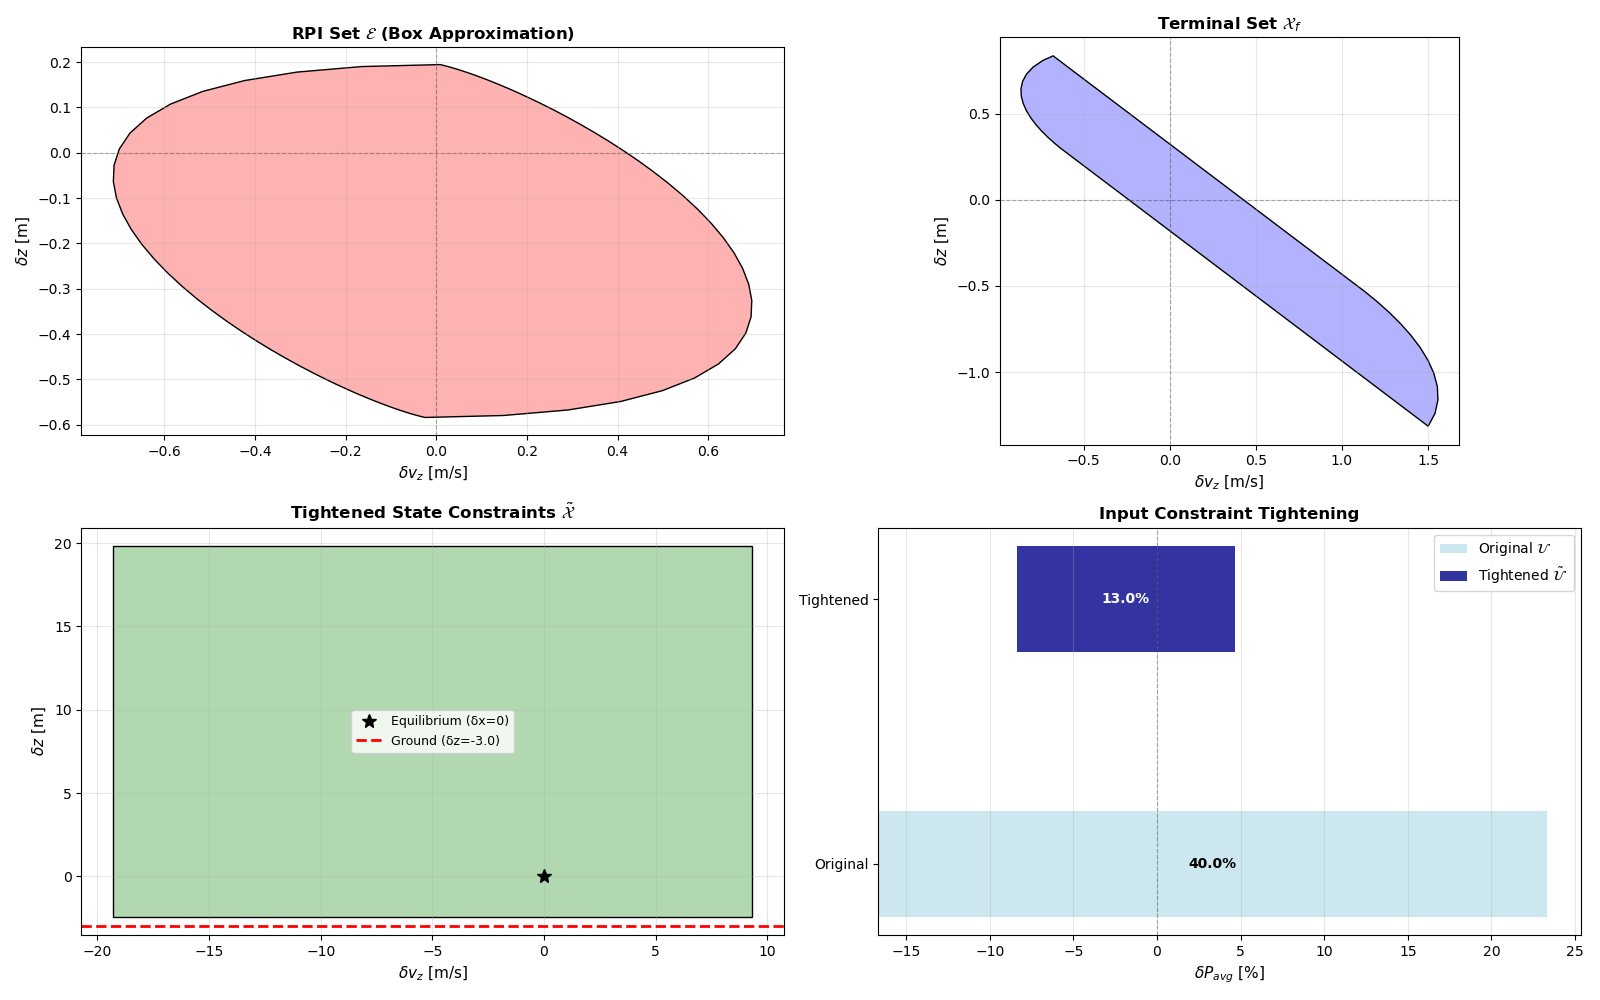

In [41]:
# Create visualization
fig = plt.figure(figsize=(16, 10))

# Layout: 2x2 grid
ax1 = plt.subplot(2, 2, 1)  # RPI set E
ax2 = plt.subplot(2, 2, 2)  # Terminal set Xf
ax3 = plt.subplot(2, 2, 3)  # Tightened state X̃
ax4 = plt.subplot(2, 2, 4)  # Input constraints comparison

# Plot 1: RPI Set E
try:
    E.plot(ax1, color='red', opacity=0.3)
    ax1.axhline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    ax1.axvline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    ax1.set_xlabel(r'$\delta v_z$ [m/s]', fontsize=11)
    ax1.set_ylabel(r'$\delta z$ [m]', fontsize=11)
    ax1.set_title('RPI Set $\\mathcal{E}$ (Box Approximation)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal', adjustable='box')
except Exception as e:
    ax1.text(0.5, 0.5, f'Error plotting E:\n{str(e)[:50]}', 
             ha='center', va='center', transform=ax1.transAxes)

# Plot 2: Terminal Set Xf
try:
    Xf.plot(ax2, color='blue', opacity=0.3)
    ax2.axhline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    ax2.axvline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    ax2.set_xlabel(r'$\delta v_z$ [m/s]', fontsize=11)
    ax2.set_ylabel(r'$\delta z$ [m]', fontsize=11)
    ax2.set_title('Terminal Set $\\mathcal{X}_f$', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal', adjustable='box')
except Exception as e:
    ax2.text(0.5, 0.5, f'Error plotting Xf:\n{str(e)[:50]}', 
             ha='center', va='center', transform=ax2.transAxes)

# Plot 3: Tightened State X̃
try:
    X_tilde.plot(ax3, color='green', opacity=0.3)
    # Mark origin
    ax3.plot(0, 0, 'k*', markersize=10, label='Equilibrium (δx=0)')
    # Mark ground constraint in delta coords
    z_ground = -xs[11]  # z=0 in absolute → δz = -xs[11] in delta
    ax3.axhline(z_ground, color='r', linestyle='--', linewidth=2, 
                label=f'Ground (δz={z_ground:.1f})')
    ax3.set_xlabel(r'$\delta v_z$ [m/s]', fontsize=11)
    ax3.set_ylabel(r'$\delta z$ [m]', fontsize=11)
    ax3.set_title('Tightened State Constraints $\\tilde{\\mathcal{X}}$', 
                  fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=9, loc='best')
except Exception as e:
    ax3.text(0.5, 0.5, f'Error plotting X_tilde:\n{str(e)[:50]}', 
             ha='center', va='center', transform=ax3.transAxes)

# Plot 4: Input Constraints Comparison
# Original vs Tightened
u_orig_min = 40.0 - us[2]
u_orig_max = 80.0 - us[2]

ax4.barh([1], [u_orig_max - u_orig_min], left=[u_orig_min], 
         height=0.4, color='lightblue', alpha=0.6, label='Original $\\mathcal{U}$')
ax4.barh([2], [mpc.u_tilde_max - mpc.u_tilde_min], left=[mpc.u_tilde_min], 
         height=0.4, color='darkblue', alpha=0.8, label='Tightened $\\tilde{\\mathcal{U}}$')

ax4.axvline(0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
ax4.set_xlabel(r'$\delta P_{avg}$ [%]', fontsize=11)
ax4.set_yticks([1, 2])
ax4.set_yticklabels(['Original', 'Tightened'])
ax4.set_title('Input Constraint Tightening', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.legend(fontsize=10)

# Add annotations
ax4.text(u_orig_min + (u_orig_max - u_orig_min)/2, 1, 
         f'{u_orig_max - u_orig_min:.1f}%', 
         ha='center', va='center', fontsize=10, fontweight='bold')
ax4.text(mpc.u_tilde_min + (mpc.u_tilde_max - mpc.u_tilde_min)/2, 2, 
         f'{mpc.u_tilde_max - mpc.u_tilde_min:.1f}%', 
         ha='center', va='center', fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

## 5. Closed-Loop Simulation: No Noise

Baseline performance without disturbances.

In [42]:

print("SIMULATING WITH NO DISTURBANCES")

try:
    t_cl_none, x_cl_none, u_cl_none = rocket.simulate_subsystem(
        mpc, sim_time, x0, w_type='no_noise'
    )
    
    print("Simulation completed successfully!")
    print(f"\nResults:")
    print(f"  Final altitude: z={x_cl_none[11, -1]:.3f}m (target: {xs[11]:.2f}m)")
    print(f"  Final velocity: vz={x_cl_none[8, -1]:.3f}m/s (target: {xs[8]:.2f}m/s)")
    print(f"  Minimum altitude: z_min={np.min(x_cl_none[11, :]):.3f}m (must be ≥0)")
    print(f"  Tracking error: Δz={abs(x_cl_none[11, -1] - xs[11]):.3f}m")
    
    if np.min(x_cl_none[11, :]) >= -1e-3:
        print(f"  [PASS] Ground constraint satisfied (z ≥ 0 for all t)")
    else:
        print(f"  [FAIL] Ground constraint violated! Min z={np.min(x_cl_none[11, :])}")
    
    z_error = np.abs(x_cl_none[11, :] - xs[11])
    settled_idx = np.where(z_error < 0.05 * xs[11])[0]
    if len(settled_idx) > 0:
        settle_time = t_cl_none[settled_idx[0]]
        print(f"  Settling time (5%): {settle_time:.2f}s")
        if settle_time <= 4.0:
            print(f"    [PASS] Meets requirement (≤4s)")
        else:
            print(f"    [NOTE] Exceeds requirement (≤4s)")
    
except Exception as e:
    print(f"[ERROR] Simulation failed: {e}")
    import traceback
    traceback.print_exc()

SIMULATING WITH NO DISTURBANCES
Simulation completed successfully!

Results:
  Final altitude: z=3.000m (target: 3.00m)
  Final velocity: vz=0.000m/s (target: 0.00m/s)
  Minimum altitude: z_min=2.969m (must be ≥0)
  Tracking error: Δz=0.000m
  [PASS] Ground constraint satisfied (z ≥ 0 for all t)
  Settling time (5%): 3.70s
    [PASS] Meets requirement (≤4s)


## 6. Closed-Loop Simulation: Random Disturbances

Test controller performance under random disturbances w ~ Uniform(W).

In [43]:

print("SIMULATING WITH RANDOM DISTURBANCES")



try:
    t_cl_rand, x_cl_rand, u_cl_rand = rocket.simulate_subsystem(
        mpc, sim_time, x0, w_type='random'
    )
    
    print("Simulation completed successfully")
    print(f"\nResults:")
    print(f"  Final altitude: z={x_cl_rand[11, -1]:.3f}m (target: {xs[11]:.2f}m)")
    print(f"  Final velocity: vz={x_cl_rand[8, -1]:.3f}m/s (target: {xs[8]:.2f}m/s)")
    print(f"  Minimum altitude: z_min={np.min(x_cl_rand[11, :]):.3f}m (must be ≥0)")
    print(f"  Tracking error: Δz={abs(x_cl_rand[11, -1] - xs[11]):.3f}m")
    
    # Check constraint satisfaction
    if np.min(x_cl_rand[11, :]) >= -1e-3:
        print(f"  Ground constraint satisfied (z ≥ 0 for all t)")
    else:
        print(f"  Ground constraint violated! Min z={np.min(x_cl_rand[11, :])}")
    
    # Settling time (within 5% of target)
    z_error = np.abs(x_cl_rand[11, :] - xs[11])
    settled_idx = np.where(z_error < 0.05 * xs[11])[0]
    if len(settled_idx) > 0:
        settle_time = t_cl_rand[settled_idx[0]]
        print(f"  Settling time (5%): {settle_time:.2f}s")
        if settle_time <= 4.0:
            print(f"  Meets requirement (≤4s)")
        else:
            print(f"  Exceeds requirement (≤4s)")
    
except Exception as e:
    print(f"Simulation failed: {e}")
    import traceback
    traceback.print_exc()

SIMULATING WITH RANDOM DISTURBANCES
Simulation completed successfully

Results:
  Final altitude: z=2.720m (target: 3.00m)
  Final velocity: vz=-0.015m/s (target: 0.00m/s)
  Minimum altitude: z_min=2.720m (must be ≥0)
  Tracking error: Δz=0.280m
  Ground constraint satisfied (z ≥ 0 for all t)
  Settling time (5%): 3.20s
  Meets requirement (≤4s)


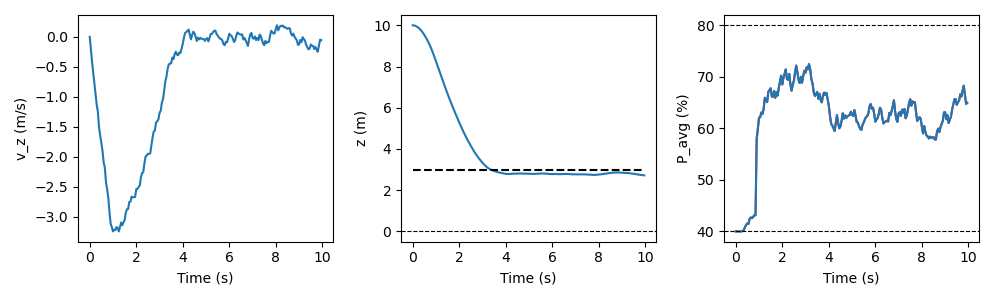

In [44]:
# Visualize trajectories
if 'x_cl_rand' in locals():
    plot_static_states_inputs(t_cl_rand[:-1], x_cl_rand[:,:-1], u_cl_rand, xs, 'sys_z')

## 7. Closed-Loop Simulation: Extreme Disturbance

Stress test with constant worst-case disturbance w = -15.

In [45]:

print("SIMULATING WITH EXTREME DISTURBANCE")


try:
    t_cl_ext, x_cl_ext, u_cl_ext = rocket.simulate_subsystem(
        mpc, sim_time, x0, w_type='extreme'
    )
    
    print("Simulation completed successfully")
    print(f"\nResults:")
    print(f"  Final altitude: z={x_cl_ext[11, -1]:.3f}m (target: {xs[11]:.2f}m)")
    print(f"  Final velocity: vz={x_cl_ext[8, -1]:.3f}m/s (target: {xs[8]:.2f}m/s)")
    print(f"  Minimum altitude: z_min={np.min(x_cl_ext[11, :]):.3f}m (must be ≥0)")
    print(f"  Tracking error: Δz={abs(x_cl_ext[11, -1] - xs[11]):.3f}m")
    
    # Check constraint satisfaction
    if np.min(x_cl_ext[11, :]) >= -1e-3:
        print(f"  Ground constraint satisfied under extreme disturbance!")
    else:
        print(f"  Ground constraint violated! Min z={np.min(x_cl_ext[11, :])}")
    
    # Input saturation check
    u_ext_pavg = u_cl_ext[2, :]
    saturated = np.sum((u_ext_pavg >= 79.9) | (u_ext_pavg <= 40.1))
    print(f"  Input saturation: {saturated}/{len(u_ext_pavg)} steps ({saturated/len(u_ext_pavg)*100:.1f}%)")
    
    print(f"  Controller handles extreme disturbance w=-15!")
    
except ValueError as e:
    if "violation" in str(e).lower():
        print(f"  Simulation failed: Constraint violation")
        print(f"  {e}")
        print(f"  Controller could not maintain z≥0 under w=-15")
        print(f"  This indicates the disturbance is too extreme for robust guarantees.")
    else:
        print(f"Simulation failed: {e}")
        import traceback
        traceback.print_exc()
except Exception as e:
    print(f"Simulation failed: {e}")
    import traceback
    traceback.print_exc()

SIMULATING WITH EXTREME DISTURBANCE
Simulation completed successfully

Results:
  Final altitude: z=2.420m (target: 3.00m)
  Final velocity: vz=0.000m/s (target: 0.00m/s)
  Minimum altitude: z_min=1.585m (must be ≥0)
  Tracking error: Δz=0.580m
  Ground constraint satisfied under extreme disturbance!
  Input saturation: 38/200 steps (19.0%)
  Controller handles extreme disturbance w=-15!


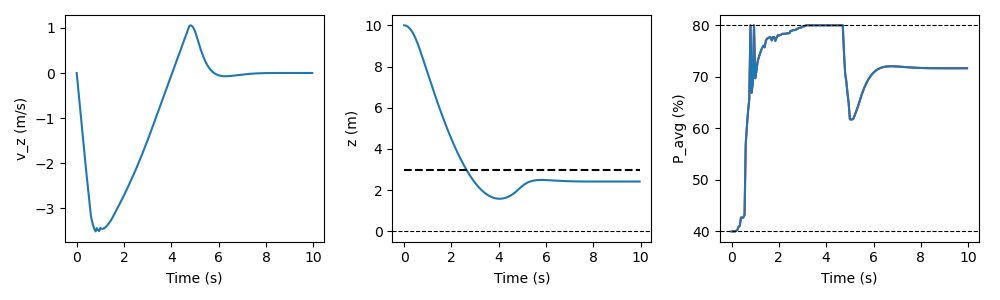

In [46]:
# Visualize trajectories
if 'x_cl_ext' in locals():
    plot_static_states_inputs(t_cl_ext[:-1], x_cl_ext[:,:-1], u_cl_ext, xs, 'sys_z')

## 8. Performance Comparison Plot


Comparison plot saved as 'deliverable_6_1_comparison.png'


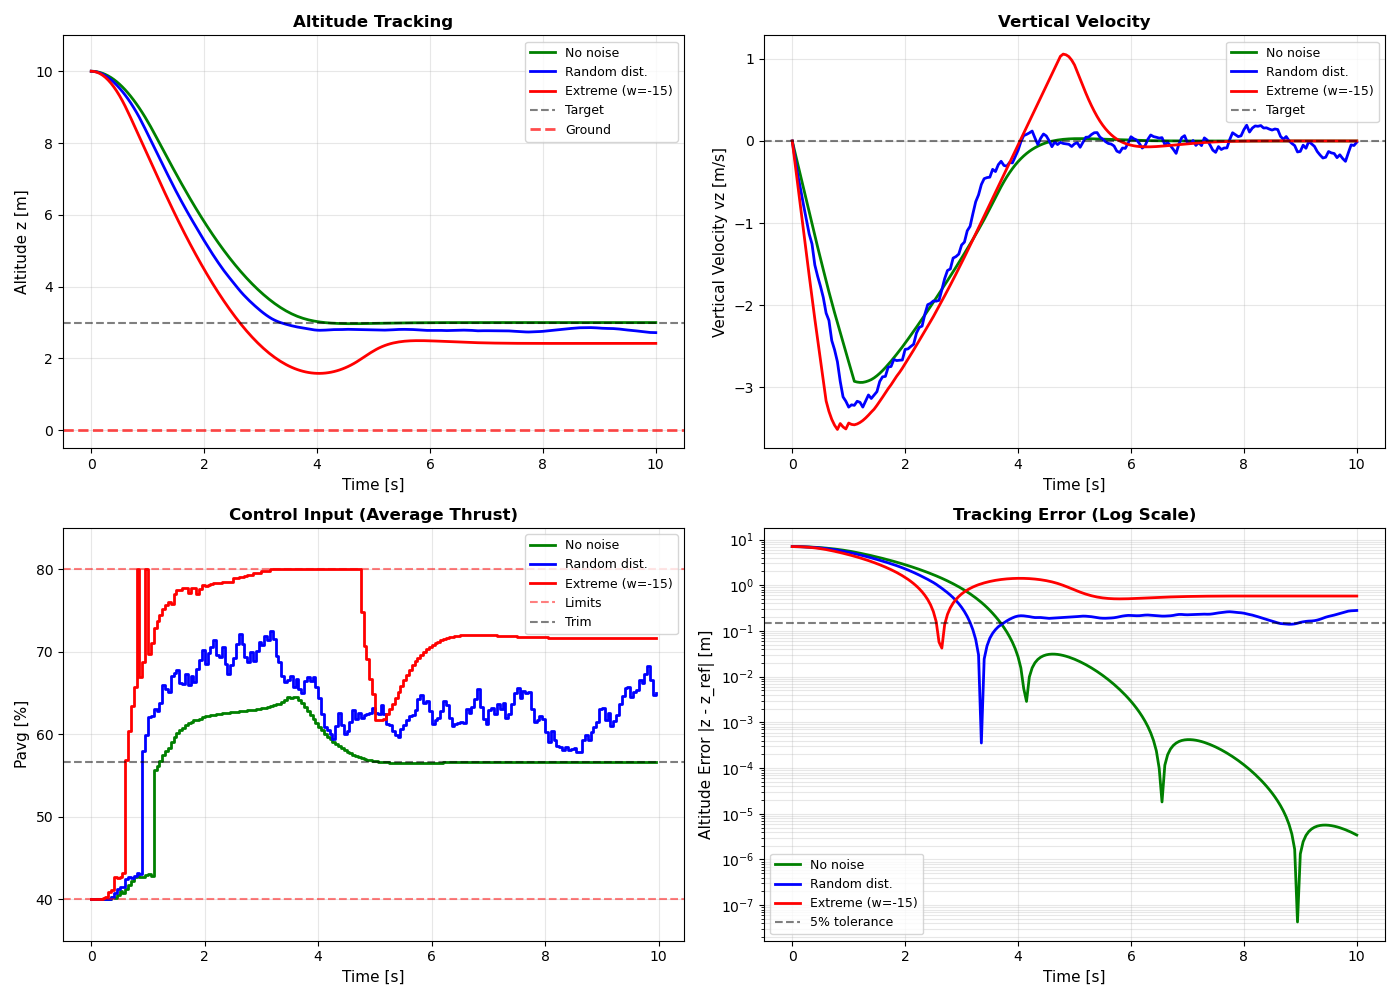

In [47]:
# Create comprehensive comparison plot
try:
    # Check if all simulation data exists
    assert 't_cl_none' in dir() and 'x_cl_none' in dir() and 'u_cl_none' in dir(), "No noise simulation data not found"
    assert 't_cl_rand' in dir() and 'x_cl_rand' in dir() and 'u_cl_rand' in dir(), "Random simulation data not found"
    assert 't_cl_ext' in dir() and 'x_cl_ext' in dir() and 'u_cl_ext' in dir(), "Extreme simulation data not found"
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Altitude
    ax = axes[0, 0]
    ax.plot(t_cl_none, x_cl_none[11, :], 'g-', linewidth=2, label='No noise')
    ax.plot(t_cl_rand, x_cl_rand[11, :], 'b-', linewidth=2, label='Random dist.')
    ax.plot(t_cl_ext, x_cl_ext[11, :], 'r-', linewidth=2, label='Extreme (w=-15)')
    ax.axhline(xs[11], color='k', linestyle='--', alpha=0.5, label='Target')
    ax.axhline(0, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Ground')
    ax.set_xlabel('Time [s]', fontsize=11)
    ax.set_ylabel('Altitude z [m]', fontsize=11)
    ax.set_title('Altitude Tracking', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    ax.set_ylim([-0.5, 11])
    
    # Velocity
    ax = axes[0, 1]
    ax.plot(t_cl_none, x_cl_none[8, :], 'g-', linewidth=2, label='No noise')
    ax.plot(t_cl_rand, x_cl_rand[8, :], 'b-', linewidth=2, label='Random dist.')
    ax.plot(t_cl_ext, x_cl_ext[8, :], 'r-', linewidth=2, label='Extreme (w=-15)')
    ax.axhline(xs[8], color='k', linestyle='--', alpha=0.5, label='Target')
    ax.set_xlabel('Time [s]', fontsize=11)
    ax.set_ylabel('Vertical Velocity vz [m/s]', fontsize=11)
    ax.set_title('Vertical Velocity', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # Input
    ax = axes[1, 0]
    ax.step(t_cl_none[:-1], u_cl_none[2, :], 'g-', where='post', linewidth=2, label='No noise')
    ax.step(t_cl_rand[:-1], u_cl_rand[2, :], 'b-', where='post', linewidth=2, label='Random dist.')
    ax.step(t_cl_ext[:-1], u_cl_ext[2, :], 'r-', where='post', linewidth=2, label='Extreme (w=-15)')
    ax.axhline(80, color='r', linestyle='--', alpha=0.5, label='Limits')
    ax.axhline(40, color='r', linestyle='--', alpha=0.5)
    ax.axhline(us[2], color='k', linestyle='--', alpha=0.5, label='Trim')
    ax.set_xlabel('Time [s]', fontsize=11)
    ax.set_ylabel('Pavg [%]', fontsize=11)
    ax.set_title('Control Input (Average Thrust)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    ax.set_ylim([35, 85])
    
    # Tracking error
    ax = axes[1, 1]
    z_err_none = np.abs(x_cl_none[11, :] - xs[11])
    z_err_rand = np.abs(x_cl_rand[11, :] - xs[11])
    z_err_ext = np.abs(x_cl_ext[11, :] - xs[11])
    ax.semilogy(t_cl_none, z_err_none, 'g-', linewidth=2, label='No noise')
    ax.semilogy(t_cl_rand, z_err_rand, 'b-', linewidth=2, label='Random dist.')
    ax.semilogy(t_cl_ext, z_err_ext, 'r-', linewidth=2, label='Extreme (w=-15)')
    ax.axhline(0.05 * xs[11], color='k', linestyle='--', alpha=0.5, label='5% tolerance')
    ax.set_xlabel('Time [s]', fontsize=11)
    ax.set_ylabel('Altitude Error |z - z_ref| [m]', fontsize=11)
    ax.set_title('Tracking Error (Log Scale)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.savefig('deliverable_6_1_comparison.png', dpi=300, bbox_inches='tight')
    print("\nComparison plot saved as 'deliverable_6_1_comparison.png'")
    plt.show()
    
except AssertionError as e:
    print(f"[WARNING] {e}")
    print("Please run all three simulation cells (5, 6, 7) before generating the comparison plot.")
except Exception as e:
    print(f"[ERROR] Failed to create comparison plot: {e}")
    import traceback
    traceback.print_exc()